#  1. Import Libries

In [61]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

# 2. Display setting

- display all the columns

In [62]:
pd.set_option("display.max_columns", None)  

- by default output of scikitlearn is numpy array.
- so we can easily convert it by writing this code

In [63]:
sklearn.set_config(transform_output="pandas")

In [64]:
warnings.filterwarnings("ignore")

# 3. Read the training data

- always all of the things do on training data like feature engineering,experimentation, analysis
- transforms are apply on the other subsets

In [65]:
path = r"C:\Users\Lenovo\OneDrive\Desktop\flights-sagemaker-project\data\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Air India,2019-03-06,Delhi,Cochin,16:40:00,19:15:00,1595,2.0,No Info,12646
1,Multiple Carriers,2019-03-03,Delhi,Cochin,07:10:00,22:20:00,910,1.0,In-flight meal not included,11125
2,Jet Airways,2019-05-15,Kolkata,Banglore,21:10:00,09:20:00,730,1.0,In-flight meal not included,9663
3,Jet Airways,2019-06-06,Delhi,Cochin,09:40:00,04:25:00,1125,2.0,In-flight meal not included,10368
4,Jet Airways,2019-05-06,Kolkata,Banglore,16:30:00,20:45:00,1695,1.0,In-flight meal not included,9663
...,...,...,...,...,...,...,...,...,...,...
635,Multiple Carriers,2019-03-21,Delhi,Cochin,08:55:00,19:15:00,620,1.0,No Info,10161
636,Air India,2019-03-27,Delhi,Cochin,20:30:00,08:15:00,705,1.0,No Info,5998
637,Spicejet,2019-04-09,Banglore,Delhi,09:30:00,12:20:00,170,0.0,No check-in baggage included,4319
638,Indigo,2019-04-18,Banglore,Delhi,13:00:00,15:50:00,170,0.0,No Info,4990


In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [67]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

# 4.Transformation Operations

## 4.1 Airline

In [68]:
X_train.airline

0                Air India
1        Multiple Carriers
2              Jet Airways
3              Jet Airways
4              Jet Airways
              ...         
635    Multiple Carriers  
636              Air India
637               Spicejet
638                 Indigo
639                 Indigo
Name: airline, Length: 640, dtype: object

 
-  imputer for imputation are used for 'Imputation transformer for completing missing values'
-  group together the rare category of airline feature like (Goair,Spicejet,Vistara,Air asia) thess are in less percentage
-  RareLabelEncoder are used for grouping category. in RareLabelEncoder tol means the grouping those category whose percentage less than 10 

In [69]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other,airline_Spicejet
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0,0.0
636,1.0,0.0,0.0,0.0,0.0,0.0
637,0.0,0.0,0.0,0.0,0.0,1.0
638,0.0,1.0,0.0,0.0,0.0,0.0


## 4.2 date_of_journey

In [70]:
X_train.date_of_journey

0      2019-03-06
1      2019-03-03
2      2019-05-15
3      2019-06-06
4      2019-05-06
          ...    
635    2019-03-21
636    2019-03-27
637    2019-04-09
638    2019-04-18
639    2019-06-03
Name: date_of_journey, Length: 640, dtype: object

In [71]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True)),
    ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.058824,0.333333,0.042373
1,0.000000,0.000000,1.000000,0.016949
2,0.666667,0.647059,0.333333,0.635593
3,1.000000,0.823529,0.500000,0.822034
4,0.666667,0.588235,0.000000,0.559322
...,...,...,...,...
635,0.000000,0.176471,0.500000,0.169492
636,0.000000,0.235294,0.333333,0.220339
637,0.333333,0.352941,0.166667,0.330508
638,0.333333,0.411765,0.500000,0.406780


## 4.3 source & destination

In [72]:
X_train.source

0         Delhi
1         Delhi
2       Kolkata
3         Delhi
4       Kolkata
         ...   
635       Delhi
636       Delhi
637    Banglore
638    Banglore
639       Delhi
Name: source, Length: 640, dtype: object

In [73]:
X_train.destination

0        Cochin
1        Cochin
2      Banglore
3        Cochin
4      Banglore
         ...   
635      Cochin
636      Cochin
637       Delhi
638       Delhi
639      Cochin
Name: destination, Length: 640, dtype: object

In [74]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Kolkata,Banglore
3,Delhi,Cochin
4,Kolkata,Banglore
...,...,...
635,Delhi,Cochin
636,Delhi,Cochin
637,Banglore,Delhi
638,Banglore,Delhi


In [75]:
print(type(location_subset))

<class 'pandas.core.frame.DataFrame'>


In [76]:
location_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source       640 non-null    object
 1   destination  640 non-null    object
dtypes: object(2)
memory usage: 10.1+ KB


In [77]:
location_subset.head()

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Kolkata,Banglore
3,Delhi,Cochin
4,Kolkata,Banglore


In [78]:
location_subset.dtypes

source         object
destination    object
dtype: object

In [79]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.065401,1.064895
1,1.065401,1.064895
2,-0.056875,-0.071605
3,1.065401,1.064895
4,-0.056875,-0.071605
...,...,...
635,1.065401,1.064895
636,1.065401,1.064895
637,-1.090368,-1.641055
638,-1.090368,-1.641055


In [80]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [81]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
      })
      .drop(columns=columns)
   )


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,1,0
637,0,1
638,0,1


In [82]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.065401,1.064895,1,0
1,1.065401,1.064895,1,0
2,-0.056875,-0.071605,1,0
3,1.065401,1.064895,1,0
4,-0.056875,-0.071605,1,0
...,...,...,...,...
635,1.065401,1.064895,1,0
636,1.065401,1.064895,1,0
637,-1.090368,-1.641055,0,1
638,-1.090368,-1.641055,0,1


## dep_time & arrival_time

In [83]:
X_train.dep_time

0      16:40:00
1      07:10:00
2      21:10:00
3      09:40:00
4      16:30:00
         ...   
635    08:55:00
636    20:30:00
637    09:30:00
638    13:00:00
639    05:05:00
Name: dep_time, Length: 640, dtype: object

In [84]:
X_train.arrival_time

0      19:15:00
1      22:20:00
2      09:20:00
3      04:25:00
4      20:45:00
         ...   
635    19:15:00
636    08:15:00
637    12:20:00
638    15:50:00
639    12:10:00
Name: arrival_time, Length: 640, dtype: object

In [85]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,16:40:00,19:15:00
1,07:10:00,22:20:00
2,21:10:00,09:20:00
3,09:40:00,04:25:00
4,16:30:00,20:45:00
...,...,...
635,08:55:00,19:15:00
636,20:30:00,08:15:00
637,09:30:00,12:20:00
638,13:00:00,15:50:00


In [86]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.695652,0.727273,0.826087,0.272727
1,0.304348,0.181818,0.956522,0.363636
2,0.913043,0.181818,0.391304,0.363636
3,0.391304,0.727273,0.173913,0.454545
4,0.695652,0.545455,0.869565,0.818182
...,...,...,...,...
635,0.347826,1.000000,0.826087,0.272727
636,0.869565,0.545455,0.347826,0.272727
637,0.391304,0.545455,0.521739,0.363636
638,0.565217,0.000000,0.652174,0.909091


In [91]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                 [X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                  X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                  X_temp.loc[:, col].between(eve, night, inclusive="left")],
                ["morning", "afternoon", "evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,evening,evening
1,morning,night
2,night,morning
3,morning,morning
4,evening,night
...,...,...
635,morning,evening
636,night,morning
637,morning,afternoon
638,afternoon,afternoon


In [92]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.131148,0.564516
1,1.000000,1.000000
2,0.213115,0.822581
3,1.000000,0.822581
4,0.131148,1.000000
...,...,...
635,1.000000,0.564516
636,0.213115,0.822581
637,1.000000,0.000000
638,0.000000,0.000000


In [93]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.695652,0.727273,0.826087,0.272727,0.131148,0.564516
1,0.304348,0.181818,0.956522,0.363636,1.000000,1.000000
2,0.913043,0.181818,0.391304,0.363636,0.213115,0.822581
3,0.391304,0.727273,0.173913,0.454545,1.000000,0.822581
4,0.695652,0.545455,0.869565,0.818182,0.131148,1.000000
...,...,...,...,...,...,...
635,0.347826,1.000000,0.826087,0.272727,1.000000,0.564516
636,0.869565,0.545455,0.347826,0.272727,0.213115,0.822581
637,0.391304,0.545455,0.521739,0.363636,1.000000,0.000000
638,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000


##  duration

In [94]:
X_train.duration

0      1595
1       910
2       730
3      1125
4      1695
       ... 
635     620
636     705
637     170
638     170
639     425
Name: duration, Length: 640, dtype: int64

In [95]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape(-1, 1)
    # .shape
)

array([[170.],
       [450.],
       [845.]])

In [101]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
        def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
            self.variables = variables
            self.percentiles = percentiles
            self.gamma = gamma


        def fit(self, X, y=None):
            if not self.variables:
                self.variables = X.select_dtypes(include="number").columns.to_list()

            self.reference_values_ = {
                col: (
                    X
                    .loc[:, col]
                    .quantile(self.percentiles)
                    .values
                    .reshape(-1, 1)
                )
                for col in self.variables
            }

            return self


        def transform(self, X):
            objects = []
            for col in self.variables:
                columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
                obj = pd.DataFrame(
                    data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                    columns=columns
                )
                objects.append(obj)
            return pd.concat(objects, axis=1)

In [102]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.0,0.000000e+00,0.904837,0.904837
1,0.0,2.506244e-162,1.000000,1.000000
2,0.0,0.000000e+00,1.000000,1.000000
3,0.0,0.000000e+00,0.904837,0.904837
4,0.0,0.000000e+00,1.000000,1.000000
...,...,...,...,...
635,0.0,0.000000e+00,1.000000,1.000000
636,0.0,0.000000e+00,1.000000,1.000000
637,0.0,0.000000e+00,0.904837,0.904837
638,0.0,0.000000e+00,0.904837,0.904837


In [103]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [104]:
def is_over(X, value=1000):
        return (
            X
            .assign(**{
                f"duration_over_{value}": X.duration.ge(value).astype(int)
            })
            .drop(columns="duration")
        )

In [105]:
    duration_pipe1 = Pipeline(steps=[
        ("rbf", RBFPercentileSimilarity()),
        ("scaler", PowerTransformer())
    ])

    duration_pipe2 = Pipeline(steps=[
        ("cat", FunctionTransformer(func=duration_category)),
        ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
    ])

    duration_union = FeatureUnion(transformer_list=[
        ("part1", duration_pipe1),
        ("part2", duration_pipe2),
        ("part3", FunctionTransformer(func=is_over)),
        ("part4", StandardScaler())
    ])

    duration_transformer = Pipeline(steps=[
        ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
        ("imputer", SimpleImputer(strategy="median")),
        ("union", duration_union)
    ])

    duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.405840,-0.144377,-0.070859,2.0,1,2.081216
1,-0.405840,-0.144377,-0.070859,2.0,0,0.657107
2,-0.405840,-0.144377,-0.070859,2.0,0,0.282889
3,-0.405840,-0.144377,-0.070859,2.0,1,1.104090
4,-0.405840,-0.144377,-0.070859,2.0,1,2.289115
...,...,...,...,...,...,...
635,-0.405840,-0.144377,-0.070859,2.0,0,0.054200
636,-0.405840,-0.144377,-0.070859,2.0,0,0.230914
637,2.796396,-0.144377,-0.070859,0.0,0,-0.881346
638,2.796396,-0.144377,-0.070859,0.0,0,-0.881346


##  total_stops

In [106]:
X_train.total_stops

0      2.0
1      1.0
2      1.0
3      2.0
4      1.0
      ... 
635    1.0
636    1.0
637    0.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [108]:
    def is_direct(X):
        return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


    total_stops_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("", FunctionTransformer(func=is_direct))
    ])

    total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,2.0,0
1,1.0,0
2,1.0,0
3,2.0,0
4,1.0,0
...,...,...
635,1.0,0
636,1.0,0
637,0.0,1
638,0.0,1


## additional_info

In [109]:
X_train.additional_info

0                           No Info
1       In-flight meal not included
2       In-flight meal not included
3       In-flight meal not included
4       In-flight meal not included
                   ...             
635                         No Info
636                         No Info
637    No check-in baggage included
638                         No Info
639                         No Info
Name: additional_info, Length: 640, dtype: object

In [110]:
    info_pipe1 = Pipeline(steps=[
        ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,0.0,1.0
638,0.0,1.0,0.0


In [111]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [112]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [113]:
info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,1
2,1.0,0.0,0.0,1
3,1.0,0.0,0.0,1
4,1.0,0.0,0.0,1
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,0.0,1.0,1
638,0.0,1.0,0.0,0


## Column Transformer

In [114]:
column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", 'destination']),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,air__airline_Spicejet,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,1.065401,1.064895,1,0,0.695652,0.727273,0.826087,0.272727,0.131148,0.564516,-0.405840,-0.144377,-0.070859,2.0,1,2.081216,2.0,0,0.0,1.0,0.0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,1.065401,1.064895,1,0,0.304348,0.181818,0.956522,0.363636,1.000000,1.000000,-0.405840,-0.144377,-0.070859,2.0,0,0.657107,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.333333,0.635593,-0.056875,-0.071605,1,0,0.913043,0.181818,0.391304,0.363636,0.213115,0.822581,-0.405840,-0.144377,-0.070859,2.0,0,0.282889,1.0,0,1.0,0.0,0.0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,1.065401,1.064895,1,0,0.391304,0.727273,0.173913,0.454545,1.000000,0.822581,-0.405840,-0.144377,-0.070859,2.0,1,1.104090,2.0,0,1.0,0.0,0.0,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.666667,0.588235,0.000000,0.559322,-0.056875,-0.071605,1,0,0.695652,0.545455,0.869565,0.818182,0.131148,1.000000,-0.405840,-0.144377,-0.070859,2.0,1,2.289115,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.176471,0.500000,0.169492,1.065401,1.064895,1,0,0.347826,1.000000,0.826087,0.272727,1.000000,0.564516,-0.405840,-0.144377,-0.070859,2.0,0,0.054200,1.0,0,0.0,1.0,0.0,0
636,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,1.065401,1.064895,1,0,0.869565,0.545455,0.347826,0.272727,0.213115,0.822581,-0.405840,-0.144377,-0.070859,2.0,0,0.230914,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,0.352941,0.166667,0.330508,-1.090368,-1.641055,0,1,0.391304,0.545455,0.521739,0.363636,1.000000,0.000000,2.796396,-0.144377,-0.070859,0.0,0,-0.881346,0.0,1,0.0,0.0,1.0,1
638,0.0,1.0,0.0,0.0,0.0,0.0,0.333333,0.411765,0.500000,0.406780,-1.090368,-1.641055,0,1,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000,2.796396,-0.144377,-0.070859,0.0,0,-0.881346,0.0,1,0.0,1.0,0.0,0


## Feature Selection

In [115]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.1
) 

##  Putting it all Together

In [116]:
preprocessor = Pipeline(steps=[
     ("ct", column_transformer),
     ("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Jet Airways,air__airline_Spicejet,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,time__arrival_time_hour,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,0.0,0.058824,0.042373,1.065401,1.064895,0.826087,-0.405840,2.0,1,2.081216,2.0,0
1,0.0,0.0,0.000000,0.016949,1.065401,1.064895,0.956522,-0.405840,2.0,0,0.657107,1.0,0
2,1.0,0.0,0.647059,0.635593,-0.056875,-0.071605,0.391304,-0.405840,2.0,0,0.282889,1.0,0
3,1.0,0.0,0.823529,0.822034,1.065401,1.064895,0.173913,-0.405840,2.0,1,1.104090,2.0,0
4,1.0,0.0,0.588235,0.559322,-0.056875,-0.071605,0.869565,-0.405840,2.0,1,2.289115,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.176471,0.169492,1.065401,1.064895,0.826087,-0.405840,2.0,0,0.054200,1.0,0
636,0.0,0.0,0.235294,0.220339,1.065401,1.064895,0.347826,-0.405840,2.0,0,0.230914,1.0,0
637,0.0,1.0,0.352941,0.330508,-1.090368,-1.641055,0.521739,2.796396,0.0,0,-0.881346,0.0,1
638,0.0,0.0,0.411765,0.406780,-1.090368,-1.641055,0.652174,2.796396,0.0,0,-0.881346,0.0,1


## Visualizations

In [117]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': -0.007450572525350936,
 'air__airline_Indigo': 0.09061665680464819,
 'air__airline_Jet Airways': 0.18754844684963748,
 'air__airline_Multiple Carriers': 0.04114751025815633,
 'air__airline_Other': 0.027665887668410605,
 'air__airline_Spicejet': 0.11312735883698828,
 'doj__date_of_journey_month': 0.07520810324899507,
 'doj__date_of_journey_week': 0.19605398432996465,
 'doj__date_of_journey_day_of_week': 0.002814465151149544,
 'doj__date_of_journey_day_of_year': 0.198782668005843,
 'location__source': 0.19452701486485083,
 'location__destination': 0.20430952024091883,
 'location__source_is_north': 0.07359887802669414,
 'location__destination_is_north': 0.07359887802669414,
 'time__dep_time_hour': 0.0046670110284984245,
 'time__dep_time_minute': 0.02644754621530776,
 'time__arrival_time_hour': 0.11181339349901868,
 'time__arrival_time_minute': 0.0246822539979669,
 'time__dep_time_part_of_day': -0.002096459050641893,
 'time__arrival_time_part_of_day': 0.067351798

In [118]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'dur__duration_rbf_50': -0.007846109467503415,
 'air__airline_Air India': -0.007450572525350936,
 'info__additional_info_No Info': -0.006377956223376742,
 'info__additional_info': -0.006377956223376742,
 'dur__duration_rbf_75': -0.004648189310640076,
 'time__dep_time_part_of_day': -0.002096459050641893,
 'doj__date_of_journey_day_of_week': 0.002814465151149544,
 'time__dep_time_hour': 0.0046670110284984245,
 'info__additional_info_In-flight meal not included': 0.005479545064895415,
 'time__arrival_time_minute': 0.0246822539979669,
 'time__dep_time_minute': 0.02644754621530776,
 'air__airline_Other': 0.027665887668410605,
 'air__airline_Multiple Carriers': 0.04114751025815633,
 'info__additional_info_Other': 0.059630662384979015,
 'time__arrival_time_part_of_day': 0.06735179880054569,
 'location__source_is_north': 0.07359887802669414,
 'location__destination_is_north': 0.07359887802669414,
 'doj__date_of_journey_month': 0.07520810324899507,
 'air__airline_Indigo': 0.09061665680464819,


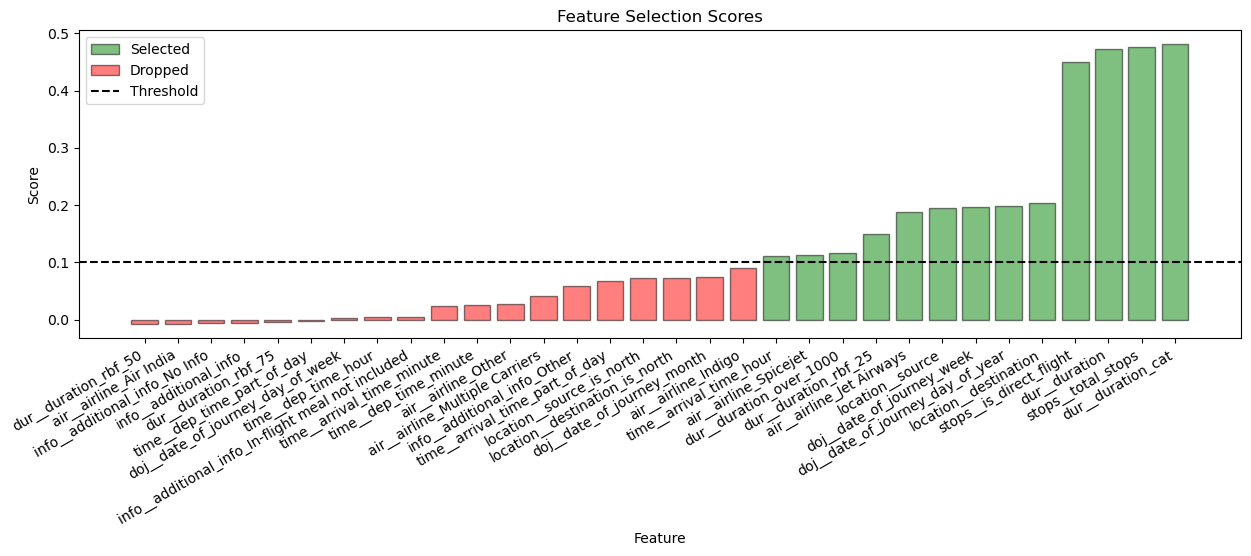

In [120]:
    THRESHOLD = 0.1

    selected_bar = None
    dropped_bar = None
    colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


    fig, ax = plt.subplots(figsize=(15, 4)) 

    for i, (feature, score) in enumerate(sorted_feat_imp.items()):
        params = dict(
            x=i,
            height=score,
            edgecolor="black",
            alpha=0.5
        )

        if score < THRESHOLD:
            bar = ax.bar(
                color="red",
                **params
            )
            if not dropped_bar:
                dropped_bar = bar[0]
        else:
            bar = ax.bar(
                color="green",
                **params
            )
            if not selected_bar:
                selected_bar = bar[0]

    thresh_line = ax.axhline(
        y=0.1,
        color="black",
        linestyle="--"
    )

    ax.set_xticks(
        ticks=range(len(sorted_feat_imp)),
        labels=list(sorted_feat_imp.keys()),
        rotation=30,
        ha="right"
    )

    ax.set(
        xlabel="Feature",
        ylabel="Score",
        title="Feature Selection Scores"
    )

    ax.legend(
        handles=[selected_bar, dropped_bar, thresh_line],
        labels=["Selected", "Dropped", "Threshold"],
        loc="upper left"
    )

    plt.show()